## Imports

In [1]:
import time
from os import listdir
from os.path import isfile, join

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from  sklearn.metrics import *
import warnings
warnings.simplefilter("ignore")

In [2]:
def get_folders(path):
    nofiles = []
    folder=path
    try:
        nofiles = [f for f in listdir(folder) if not isfile(join(folder, f))]
    except:
        print("FileNotFoundError: [Errno 2] No such file or directory: "+path)
    return nofiles


In [3]:
if not torch.cuda.is_available():
    raise Exception("You should enable GPU in the runtime menu.")
device = torch.device("cuda")

## Modeler

In [4]:
# device ha d'existir

class Modeler():
    def __init__(self, net=None, classifier=None, entrada=8192, sortida=85, freeze_to=30, print_model=True):
        self.print_model = print_model
        self.entrada = entrada
        self.sortida = sortida
        if classifier is None:
            self.classifier = self.get_classifier(entrada, sortida)
        else:
            self.classifier = classifier
        if net is None:
            self.net = self.get_net()
        else:
            self.net = net
        
        self.feature_extractor = self.net.features
        self.freezer(freeze_to)
        self.model = self.get_model()
        
        
    def get_classifier(self, entrada, sortida):
        if entrada is None or sortida is None:
            raise ValueError('ERROR: entrada o sortida no poden ser None.')
        feature_classifier = nn.Sequential(
                                nn.Linear(entrada, 256),
                                nn.ReLU(),
            
                                nn.Dropout(0.5),
                                #nn.Linear(256, 256),
                                #nn.ReLU(),
                                nn.Linear(256, sortida),
                                nn.Tanh()
                        )
        print('Classifier ('+str(entrada)+','+str(sortida)+ ') gotten')
        return feature_classifier 
    
    def get_net(self):
        net = vgg16(pretrained=True)
        print('Vgg16 gotten')
        return net
        
    def freezer(self, slice_):
        slice_+=1
        for layer in self.feature_extractor[:slice_]:  # Freeze layers 
            for param in layer.parameters():
                param.requires_grad = False
        print('Freezed to: '+str(slice_-1))
        
    def get_model(self):
        model = nn.Sequential(
            self.feature_extractor,
            #nn.AdaptiveAvgPool2d(output_size=(7, 7)),
            nn.Flatten(),
            self.classifier
            )
        if self.print_model:
            display(model.to(device))
        else:
            model.to(device)
        return model

## Transforms

In [5]:

transform_0 = transforms.Compose([
        transforms.RandomResizedCrop(150),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

transform_1 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_2 = transforms.Compose([
    transforms.Resize(150), # Resize the short side of the image to 150 keeping aspect ratio
    transforms.CenterCrop(150), # Crop a square in the center of the image
    transforms.ToTensor(), # Convert the image to a tensor with pixels in the range [0, 1]
    ])

transform_3 = transforms.Compose([
    transforms.Resize(150), # Resize the short side of the image to 150 keeping aspect ratio
    transforms.RandomCrop(150), # Crop a square in the center of the image
    transforms.ToTensor(), # Convert the image to a tensor with pixels in the range [0, 1]
    ])

transform_4 = transforms.Compose([
    transforms.Resize(150), 
    transforms.CenterCrop(150), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

#Apliquem data augmentation
#train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(45), transforms.RandomResizedCrop(224), transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(150),
    transforms.ToTensor(),
    #transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


#val_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

val_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(150), 
    transforms.ToTensor(),
    #transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


## Weigthed Sampler

In [6]:
def balanced_weights(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = float(nclasses)/(N*float(count[i]))                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight

In [7]:
def sampler(dataset):
    weights = balanced_weights(dataset.imgs, len(dataset.classes))                                                                
    weights = torch.DoubleTensor(weights)                                       
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    return sampler

## Loaders

In [8]:
def get_train_val_loaders(root, transform=transform_2, batch_size=32, workers=2):
    train_dir=root+'train'
    validation_dir=root+'validation'

    #train set
    train_dataset = ImageFolder(train_dir, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size,sampler=sampler(train_dataset),
                              num_workers=workers)

    #validation set
    val_dataset = ImageFolder(validation_dir, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=workers)
    
    return train_loader, val_loader

In [9]:
def get_dataloader(root, transform, num_workers=0, batch_size=32, sampling=True):
    snake_train = datasets.ImageFolder(root=root, transform=transform)
    if sampling:
        sampl=sampler(snake_train)
        # ValueError: sampler option is mutually exclusive with shuffle
        trainloader = torch.utils.data.DataLoader(snake_train, batch_size=batch_size,
                                        sampler=sampl, num_workers=num_workers)
    else:
        trainloader = torch.utils.data.DataLoader(snake_train, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)
    return trainloader

## trainer 2

In [10]:
import copy
def train_model2(model, dataloader_train,dataloader_val,criterion, optimizer,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #running_f1 = 0

            # Iterate over data.
            if phase == 'train': 
                for inputs, labels in dataloader_train:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
 
            if phase == 'val': 
                for inputs, labels in dataloader_val:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            #scheduler.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                epoch_loss = running_loss / len(dataloader_train)
                epoch_acc = running_corrects.double() / len(dataloader_train)
                
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                
            if phase == 'val':
                epoch_loss = running_loss / len(dataloader_val)
                epoch_acc = running_corrects.double() / len(dataloader_val)
                
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            time_elapsed = time.time() - since
            print('Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        #torch.save(model, './models/vgg3_model.pth')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, 'snakes_vgg.pth')
    return model, train_loss, val_loss, train_acc, val_acc

## Trainer

In [11]:
class Trainer():
    def __init__(self, trainloader, epochs=2):
        self.trainloader = trainloader
        self.epochs = epochs
    
    def train(self, model):
        print('Training...')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        trainloader = self.trainloader
        epochs = self.epochs
        t = time.time()
        model.train()
        correct=0
        total=0
        for epoch in range(epochs):  # loop over the dataset multiple times

            for i, data in enumerate(trainloader):
                # get the inputs to gpu; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                accy = correct / total*100

                # print statistics
                if i % 300 == 299:    # print every 300 mini-batches
                    print(f"Epoch {epoch+1}/{epochs} [{i+1}/{len(trainloader)}] loss: {loss.item():.2f} , time: {(time.time() - t):.1f}s , accuracy: {(accy):.1f}%")
        print('Finished Training')
    
    def accuracy(self, model, loader):
        print('Calculating accuracy...')
        correct = 0
        total = 0
        t = time.time()
        model.eval()
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Time end: {(time.time() - t):.1f}s")

        print(f"Accuracy of the network on the train images: {correct / total*100:.1f}%")
        
    def accuracy_prec_recall_final(self, root, model, loader):
        num_classes = len(get_folders(root))
        precision = []
        recall = []
        t = time.time()
        model.eval()
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            cur_recall = recall_score(labels.cpu().data.numpy(),predicted.cpu().data.numpy(),average='weighted')
            recall.append(cur_recall)
            cur_precision = precision_score(labels.cpu().data.numpy(),predicted.cpu().data.numpy(),average='weighted')
            precision.append(cur_precision)
        avg_prec = np.asarray(precision).mean()
        avg_recall = np.asarray(recall).mean()
        print(f"Time end: {(time.time() - t):.1f}s")
        print(f"Average precision of the network: {round(avg_prec*100,2)}%")
        print(f"Average recall of the network: {round(avg_recall*100,2)}%")
        return precision, recall 

## Process    

In [12]:
# 25088    -   4 * 4 * 512

def process(freeze_to=28, epochs=2, root='./train_2/',num_workers=3,
            batch_size=32, train_val=False):
    
    sortida = len(get_folders(root))
    print("Num output classes:",sortida)
    
    #entrada=25088
    mmx = Modeler(sortida=sortida, freeze_to=freeze_to, print_model=False).model
    
    if train_val:
        loader_train, loader_test = get_train_val_loaders(root,batch_size=batch_size,workers=num_workers)
        
    else:
    
        loader_train = get_dataloader(root, transform_2, num_workers=num_workers, batch_size=batch_size)
        loader_test = get_dataloader(root, transform_2 ,num_workers=num_workers, batch_size=batch_size)
    

    
    trainer = Trainer(loader_train, epochs=epochs)
    trainer.train(mmx)
    #trainer.accuracy_prec_recall_final(root,mmx, loader_test)
    
    return trainer

## Call process

In [13]:

#trainIns = process(freeze_to=28, epochs=30, root='./train_processed2/train/',num_workers=10,batch_size=128)

## STANDALONE Train - Validation Process 

In [14]:
train_dir='train_processed/train'
validation_dir='train_processed/validation'
train_transform = transform_2
val_transform = transform_2

batch_size = 128
num_workers = 10

#ImageFolder i Dataloader
#train set
train_dataset = ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,sampler=sampler(train_dataset),
                          num_workers=num_workers)

#validation set
val_dataset = ImageFolder(validation_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers)

# Model
model = Modeler(sortida=85, freeze_to=28, print_model=False).model

# Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Call train_model2
model_vgg, train_loss, val_loss, train_acc, val_acc=train_model2(model,
                                                                 train_loader,
                                                                 val_loader,
                                                                 loss_fn,
                                                                 optimizer,  10)

Classifier (8192,85) gotten
Vgg16 gotten
Freezed to: 28
Epoch 0/9
----------
train Loss: 489.9418 Acc: 19.0210
Time 4m 36s
val Loss: 480.6975 Acc: 17.5567
Time 5m 58s

Epoch 1/9
----------
train Loss: 462.0690 Acc: 26.3637
Time 10m 34s
val Loss: 482.0447 Acc: 16.4483
Time 11m 56s

Epoch 2/9
----------
train Loss: 452.7678 Acc: 29.2626
Time 16m 32s
val Loss: 479.2371 Acc: 18.3941
Time 17m 53s

Epoch 3/9
----------
train Loss: 446.7110 Acc: 31.2922
Time 22m 27s
val Loss: 473.6787 Acc: 19.0542
Time 23m 48s

Epoch 4/9
----------
train Loss: 441.9420 Acc: 32.6695
Time 28m 29s
val Loss: 471.5216 Acc: 20.9212
Time 29m 51s

Epoch 5/9
----------
train Loss: 439.5095 Acc: 33.4612
Time 34m 14s
val Loss: 477.5400 Acc: 19.3645
Time 35m 35s

Epoch 6/9
----------
train Loss: 436.4401 Acc: 34.8989
Time 40m 0s
val Loss: 474.1932 Acc: 19.6158
Time 41m 18s

Epoch 7/9
----------
train Loss: 434.6088 Acc: 35.2207
Time 45m 43s
val Loss: 476.1788 Acc: 19.1182
Time 47m 4s

Epoch 8/9
----------
train Loss: 431

In [15]:
root='train_processed/train'
trainer = Trainer(train_loader)
pr, rec = trainer.accuracy_prec_recall_final(root,model_vgg, val_loader)

Time end: 78.2s
Average precision of the network: 94.91%
Average recall of the network: 16.51%


## Plot Train - Validation: Accuracy + Loss

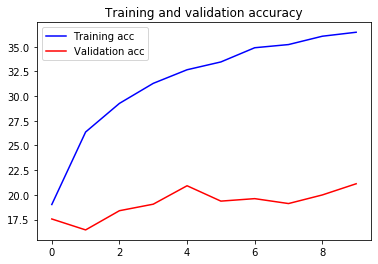

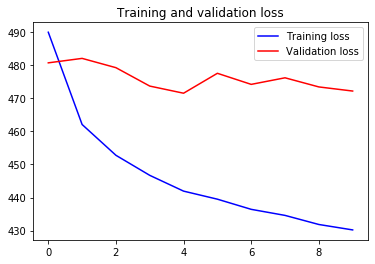

In [18]:
import matplotlib.pyplot as plt
epochs = range(len(train_acc))

plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
print(train_loss,"\n", val_loss,"\n", train_acc,"\n", val_acc)

In [ ]:
# R01: Accuracy con 2 epoch, y dataset original, sin pesos, vgg hasta flatten congelado: 4.9%
# R02: Accuracy con 2 epoch, sin dropouts, train_2, vgg hasta flatten congelado: 4.8%
# R03: Accuracy amb 2 epoch, dataset train_2, classes[q1,q3], no dropout vgg fins flatten congelat: 19.5%
# R04: Accuracy amb 2 epoch, dataset train_2, classes[q1,q3], no dropout vgg fins capa 27 congelat: 1.6%
# R05: process(sortida=43, freeze_to=29, epochs=2, root='./train_2/') --> VGG = 22.2, 20.7
# R06: process(sortida=43, freeze_to=28, epochs=2, root='./train_2/') --> VGG = 21.0%, 22.9
# R07: process(sortida=43, freeze_to=28, epochs=2, root='./train_2/') VGG + normalize --> 26.1%
# R08: process(freeze_to=28, epochs=2, root='./train_2/') classes=82, VGG, normalize --> 10.9% classes entre 200 i 500 imatges
# R09: Accuracy amb freeze_to=28, root='./train_2/', epochs = 2, i sense 2 capes intermitges al classificador: 17.8%
# R10: R09 + amb freeze_to=29 +normalització ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) --> 17.5%
# R11: R10 + freeze_to=28 + 5 epochs --> 28.7%
# R12: R11 + WeightedRandomSampler --> 30.7%
# R13: R12 + Softmax --> 14.3%
# R14: R12 + Tanh --> 31.8%
# R15: R14 + 2 epoch --> 29.0%
# R15b: R15 + 1 epoch --> 16.5% (workers=3, batch_size=32)
# R16: R15 + transform_0 + transform_4 --> 15.4%
# R16b: R16 + 5 epoch --> 14.2%
# R17: R16 + 1 epoch --> 15.6%
# R18: R14, 5 epoch, num_workers=10, batch_size=128 --> 48.8%, (47.7% 128=128 classifier)
# R19: R14, 3 epoch, num_workers=3, batch_size=32  --> 18.1%
# R20: R14, 10 epoch, num_workers=10, batch_size=128 --> 56.1%
# R21: R14, 5 epoch, num_workers=10, batch_size=128 train_images --> 40.0% (ds ori)
# R22: R14, 15 epoch, num_workers=10, batch_size=128 train_2 --> 59.2% 
# R23: R14, 15 epoch, num_workers=2, batch_size=32 train_2 --> 16.1% 
# R24: R14, 5 epoch, transform_2, num_workers=2, batch_size=48 train_2 --> 38.9% 
# R25: R14, 20 epoch, num_workers=10, batch_size=128 train_2 --> 63.3% 
# R26: R14, 25 epoch, num_workers=10, batch_size=128 train_2 --> 62.1% 
# R27: R24 + 10 epoch, num_workers=10, batch_size=128 train_2 --> 63.0% 
# R28: R24 + 20 epoch, num_workers=10, batch_size=128 train_2 --> 72.5% 
# R29: R24 + 10 epoch, freeze_to=29, num_workers=10, batch_size=128 train_2 --> 64.2% 

In [ ]:
import pandas as pd
import seaborn as sns


In [ ]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
'''
loader = get_loader(root,transform)
    print('loader len = ',loader.dataset.shape)
    spl = int(loader.dataset.shape * 0.7)
    
    trainloader = loader.dataset.data[:spl, :, :]
    testloader = loader.dataset.data[spl:, :, :]
    print('trainloader len = ',trainloader.shape)
    print('testloader len = ',testloader.shape)
'''